In [32]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1
CUDA status:  True
CUDA memory max alloc:     5426 MB


In [33]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

In [34]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [35]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Validate WildCat model on the test set

In [36]:
# Set global properties
num_classes=2
input_size=224
batch_size=16
data_dir = "/home/pyushkevich/data/twoway"

In [37]:
# Read the model
model_ft = wildcat.models.resnet50_wildcat(2, pretrained=False, kmax=0.2, alpha=0.7, num_maps=4)
model_ft.load_state_dict(torch.load('/home/pyushkevich/resnet/my_wildcat_50_30epoch_k02.dat'))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [38]:
# Create a data loader
dt = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

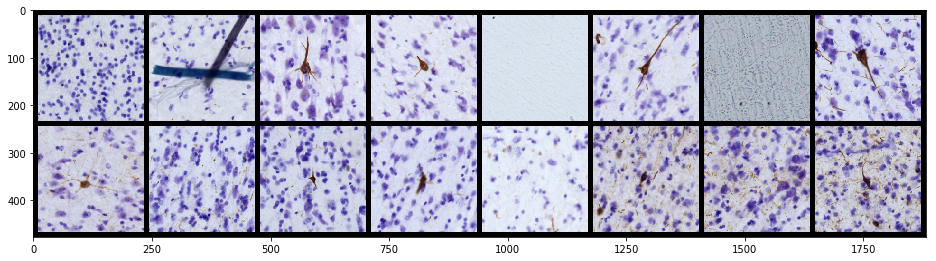

In [39]:
# Read a batch of data
img,label,paths=next(iter(dl))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))

In [40]:
# Evaluate model on this batch
model_ft.eval()
img_d = img.to(device)
label_d = label.to(device)
outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)


(tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]),
 tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]))

In [41]:
# Perform full test set evaluation and save examples of errors
cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
path_fp = []
path_fn = []
for img,label,paths in dl:
    img_d = img.to(device)
    label_d = label.to(device)
    outputs = model_ft(img_d)
    _, preds = torch.max(outputs, 1)
    for a in range(0,len(label)):
        l_pred = preds.cpu()[a].item()
        l_true = label[a].item()
        cm[l_pred,l_true]=cm[l_pred,l_true]+1
        if l_pred == 1 and l_true == 0:
            # False positive (non-tangle classified as tangle)
            img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
            path_fp.append(paths[a]) 
        elif l_pred == 0 and l_true == 1:
            # False negative (tangle classified as non-tangle)
            img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
            path_fn.append(paths[a]) 

cm

array([[327.,   8.],
       [ 23., 251.]])

In [42]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9490968801313628

['/home/pyushkevich/data/data/ambiguous/540.png',
 '/home/pyushkevich/data/data/threads/211.png',
 '/home/pyushkevich/data/data/dirt/1871.png',
 '/home/pyushkevich/data/data/astrocyte_tau/1761.png',
 '/home/pyushkevich/data/data/artifact/2940.png',
 '/home/pyushkevich/data/data/threads/1740.png',
 '/home/pyushkevich/data/data/dirt/1180.png',
 '/home/pyushkevich/data/data/threads/300.png',
 '/home/pyushkevich/data/data/tissue_fold/2781.png',
 '/home/pyushkevich/data/data/threads/1571.png',
 '/home/pyushkevich/data/data/ambiguous/2791.png',
 '/home/pyushkevich/data/data/astrocyte_tau/591.png',
 '/home/pyushkevich/data/data/threads/2621.png',
 '/home/pyushkevich/data/data/dirt/991.png',
 '/home/pyushkevich/data/data/artifact/1970.png',
 '/home/pyushkevich/data/data/threads/660.png',
 '/home/pyushkevich/data/data/threads/1500.png',
 '/home/pyushkevich/data/data/threads/1630.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2790.png',
 '/home/pyushkevich/data/data/threads/900.png',
 '/home/

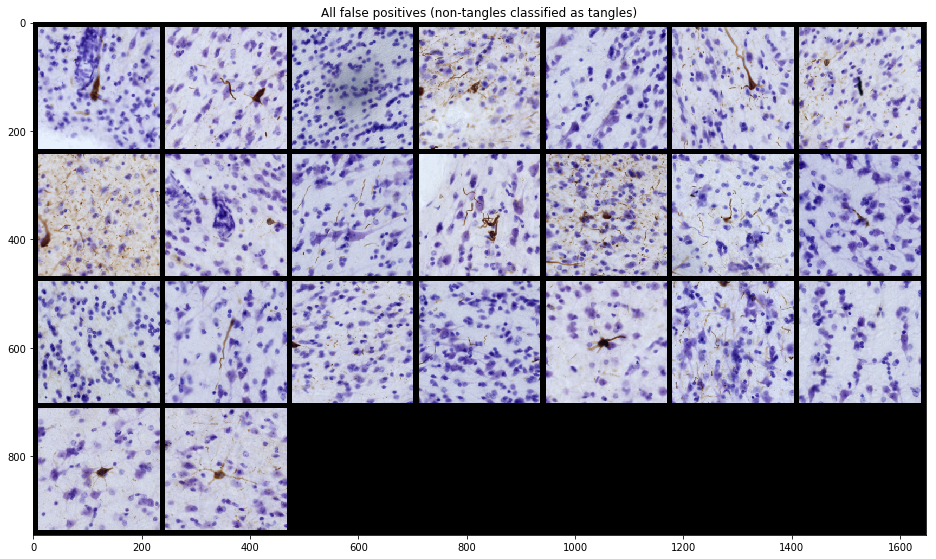

In [43]:
# Plot the false positives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fp, padding=10, nrow=7, normalize=True))
plt.title("All false positives (non-tangles classified as tangles)");
list(map(os.path.realpath, path_fp))

['/home/pyushkevich/data/data/tangle/2140.png',
 '/home/pyushkevich/data/data/tangle/2941.png',
 '/home/pyushkevich/data/data/tangle/1981.png',
 '/home/pyushkevich/data/data/tangle/391.png',
 '/home/pyushkevich/data/data/tangle/2821.png',
 '/home/pyushkevich/data/data/tangle/2911.png',
 '/home/pyushkevich/data/data/tangle/2681.png',
 '/home/pyushkevich/data/data/tangle/940.png']

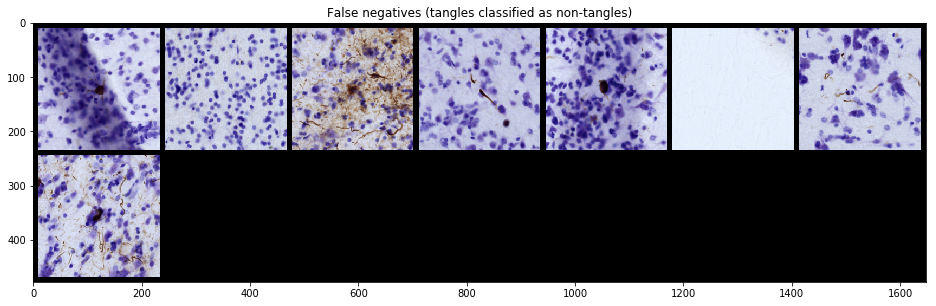

In [44]:
# Plot the false negatives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fn, padding=10, nrow=7, normalize=True))
plt.title("False negatives (tangles classified as non-tangles)");
list(map(os.path.realpath, path_fn))

## Examine layers in the Wildcat model

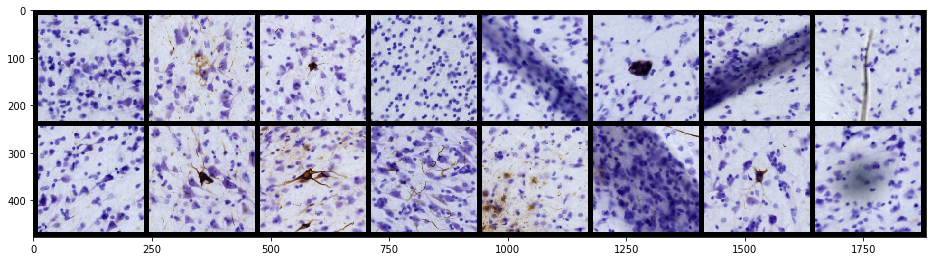

In [45]:
# Read a batch of data again
img,label,paths=next(iter(dl))
img_d = img.to(device)
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))

In [46]:
# Do a manual forward run of the model
x_feat = model_ft.features(img_d)
x_clas = model_ft.classifier(x_feat)
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)
x_spool = model_ft.spatial_pooling.spatial(x_cpool)

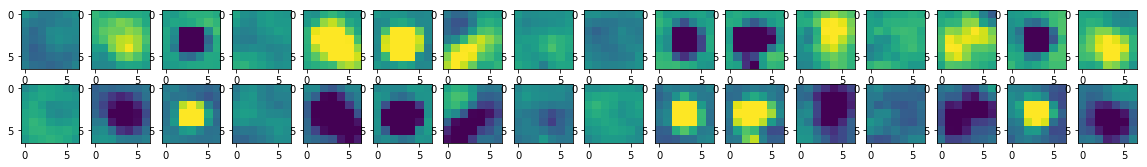

In [47]:
plt.figure(figsize=(20,2.5))
for i in range(0, batch_size):
    for j in range(0, 2):
        plt.subplot(2, batch_size, i  + j * batch_size + 1)
        plt.imshow(x_cpool[i,j,:,:].cpu().detach().numpy(), vmin=-10, vmax=10)

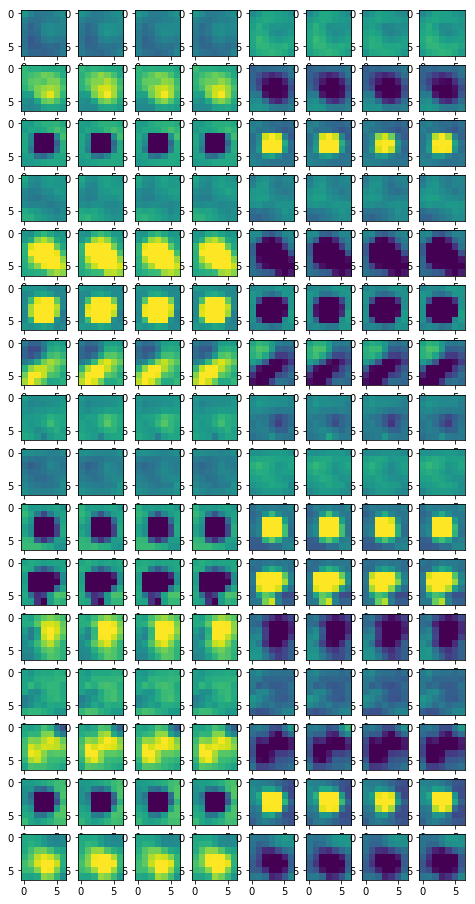

In [48]:
plt.figure(figsize=(8,16))
for i in range(0, batch_size):
    for j in range(0, x_clas.shape[1]):
        plt.subplot(batch_size, x_clas.shape[1], i * x_clas.shape[1] + j + 1)
        plt.imshow(x_clas[i,j,:,:].cpu().detach().numpy(), vmin=-10, vmax=10)

# Direct Classification of OpenSlide Images

In [ ]:
import openslide

In [ ]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/285342.svs')
osl.get_thumbnail((512,512))

In [ ]:
# Pull out a little region of the image
osl.read_region((40350,20300),0,(512,512))

In [ ]:
# Strides in pixels
stride=100

# Window size in strides
window_size=4

# Strides per chunk
chunk_size=40

# Determine the actual width of the image needed for this chunk
chunk_width=stride*(chunk_size+window_size-1)
print("Chunk width: ", chunk_width)

# Determine the dimensions of the output image
out_dim=(np.array(osl.dimensions)/stride - window_size + 1).astype(int)
out_pnt=np.zeros(out_dim)
out_ptg=np.zeros(out_dim)

# Transformed stride and width
stride_t = int(input_size / window_size)

# Start at some position
# u_0 = 200; v_0 = 200;
# u_1 = 290; v_1 = 260;
u_0 = 0; u_1 = out_dim[0];
v_0 = 0; v_1 = out_dim[1];

t_start = timeit.default_timer()

# Range over u and v
for u in range(u_0, u_1, chunk_size):
    for v in range(v_0, v_1, chunk_size):
        
        # The actual dimension of the region in steps
        cs_u = min(u_1 - u, chunk_size)
        cs_v = min(v_1 - v, chunk_size)
        
        # Chunk size in pixels - what to read from the image
        csp_u = stride * (cs_u + window_size - 1)
        csp_v = stride * (cs_v + window_size - 1)

        # Read the chunk
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((u*stride, v*stride), 0, (csp_u, csp_v)).convert("RGB")

        t1 = timeit.default_timer()
        
        # Transform the chunk
        chunk_dt = transforms.Compose([
                transforms.Resize(int(stride_t*(min(cs_u, cs_v)+window_size-1))),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        chunk_tensor=chunk_dt(chunk_img).to(device)
        chunk_ufold=chunk_tensor.unfold(1,input_size,stride_t).unfold(2,input_size,stride_t).permute((1,2,0,3,4))

        # Process batches
        t2 = timeit.default_timer()

        for i in range(0,cs_u):
            y_i = model_ft(chunk_ufold[:,i,:,:,:]).cpu().detach().numpy()
            for j in range(0,cs_v):
                out_pnt[u+i:u+i+window_size,v+j:v+j+window_size] += y_i[j,0]
                out_ptg[u+i:u+i+window_size,v+j:v+j+window_size] += y_i[j,1]
            
        t3 = timeit.default_timer()
        
        # Report
        print("Completed chunk (%d,%d), t_read=%8.4f  t_ufld=%8.4f  t_cnn=%8.4f  t=%8.4f" %
              (u, v, t1-t0, t2-t1, t3-t2, t3-t0))

t_end = timeit.default_timer()
print("Total time elapsed: ", t_end - t_start)

In [ ]:
# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample):
    # The image region
    img_rgn=osl.read_region((u0*stride,v0*stride), d_sample,
                            (int((u1-u0)*stride/osl.level_downsamples[d_sample]),
                             int((v1-v0)*stride/osl.level_downsamples[d_sample])))
    
    # The tangle map
    t_map=out_ptg[u0:u1,v0:v1].transpose()-out_pnt[u0:u1,v0:v1].transpose()
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=-500, vmax=500, extent=(u0,u1,v1,v0))
    # ax[1].colorbar(cs)
    fig.show()

#os.level_downsamples
#os.read_region((u_0*stride,v_0*stride),1,(int((u_1-u_0)*stride/os.level_downsamples[1]),int((v_1-v_0)*stride/os.level_downsamples[1])))

In [ ]:
# Plot the entire extent of the slide
plot_classification_region(0,0,out_dim[0],out_dim[1],3)

In [ ]:
plot_classification_region(100,50,400,300,2)

In [ ]:
plot_classification_region(350,240,400,270,1)

In [ ]:
plot_classification_region(370,250,380,260,0)